In [1]:
from logging import warning
import os 
import pandas as pd
import numpy as np
import pickle 

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, make_scorer, confusion_matrix
from xgboost import XGBClassifier

import warnings

import processing
import event_manager
import epoching 
import model_training

warnings.filterwarnings('ignore')

<h1> Training ML <h1>

In [2]:
file = '../../data/data_model/data_sound_event_mel_norm_augmented_mean.ftr'
file = '../../data/data_model/data_sound_event_mel_norm.ftr'

In [3]:
if file.endswith('.csv'):
    data= pd.read_csv(file,index_col=0)
elif file.endswith('.ftr'):
    data= pd.read_feather(file)
data = data[data.label!=3]
data.label.value_counts()

0    23866
2     9325
1     3841
Name: label, dtype: int64

In [4]:
df = pd.read_csv('../../data/filename_train_test.txt',delimiter='\t',header=None)
df.columns=['file','train_test_split']
data = data.merge(df,on='file',how='left')

In [5]:
data['Subject_ID'] = data['file'].str.split('_').str[0]
data['Location'] = data['file'].str.split('_').str[2]
data['Device'] = data['file'].str.split('_').str[4]

In [6]:
data = model_training.select_n_sample(data,120000)

In [6]:
data

,0,1,2,3,4,5,6,7,8,9,...,59,start,end,label,duration,file,train_test_split,Subject_ID,Location,Device
0,0.0,0.0,0.491091,0.524232,0.0,0.0,0.526058,0.479050,0.0,0.330702,...,0.009184,2.207,2.407,1,0.200,122_2b1_Tc_mc_LittC2SE,train,122,Tc,LittC2SE
1,0.0,0.0,0.683311,0.716452,0.0,0.0,0.678207,0.631199,0.0,0.491045,...,0.002629,5.693,5.864,1,0.171,122_2b1_Tc_mc_LittC2SE,train,122,Tc,LittC2SE
2,0.0,0.0,0.592490,0.625631,0.0,0.0,0.641540,0.594532,0.0,0.480375,...,0.001639,5.907,6.579,1,0.672,122_2b1_Tc_mc_LittC2SE,train,122,Tc,LittC2SE
3,0.0,0.0,0.574145,0.607287,0.0,0.0,0.593997,0.546989,0.0,0.409722,...,0.005576,9.093,9.321,1,0.228,122_2b1_Tc_mc_LittC2SE,train,122,Tc,LittC2SE
4,0.0,0.0,0.493466,0.526607,0.0,0.0,0.533213,0.486205,0.0,0.373734,...,0.002783,12.807,13.521,1,0.714,122_2b1_Tc_mc_LittC2SE,train,122,Tc,LittC2SE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37027,0.0,0.0,0.730766,0.763907,0.0,0.0,0.766946,0.719938,0.0,0.488053,...,0.053495,13.341,13.376,2,0.035,154_3b3_Ar_mc_AKGC417L,train,154,Ar,AKGC417L
37028,0.0,0.0,0.652542,0.685683,0.0,0.0,0.674778,0.627770,0.0,0.455821,...,0.000000,14.820,14.845,2,0.025,154_3b3_Ar_mc_AKGC417L,train,154,Ar,AKGC417L
37029,0.0,0.0,0.581646,0.614787,0.0,0.0,0.608576,0.561568,0.0,0.288784,...,0.000000,15.905,15.943,2,0.038,154_3b3_Ar_mc_AKGC417L,train,154,Ar,AKGC417L
37030,0.0,0.0,0.544859,0.578001,0.0,0.0,0.586367,0.539358,0.0,0.359318,...,0.000000,16.226,16.251,2,0.025,154_3b3_Ar_mc_AKGC417L,train,154,Ar,AKGC417L


In [7]:
import sklearn 

SubjectID = sklearn.utils.shuffle(data.Subject_ID.unique())
SubjectID_train = SubjectID[:100]
SubjectID_test = SubjectID[100:]
data['train_test_split'] = np.where(data['Subject_ID'].isin(SubjectID_train),'train','test')

In [12]:
X_train = data[data['train_test_split'] == 'train'].drop(columns=['start', 'end', 'label', 'file','train_test_split','Subject_ID','Location','Device']).to_numpy()
X_test = data[data['train_test_split'] == 'test'].drop(columns=['start', 'end', 'label', 'file','train_test_split','Subject_ID','Location','Device']).to_numpy()
y_train = data.loc[data['train_test_split'] == 'train','label'].to_numpy()
y_test = data.loc[data['train_test_split'] == 'test','label'].to_numpy()
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(29848, 61) (29848,)
(7184, 61) (7184,)


In [13]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [16]:
X_train.shape

(29848, 5)

In [17]:
logistic = XGBClassifier()
#logistic.fit(X_train,y_train)
logistic.fit(X_train,y_train,sample_weight=classes_weights)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [18]:
ytest_predict = logistic.predict(X_test)
print(classification_report(y_pred=ytest_predict,y_true=y_test))
print(confusion_matrix(y_pred=ytest_predict,y_true=y_test))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      4316
           1       0.43      0.42      0.43      1120
           2       0.93      0.70      0.80      1748

    accuracy                           0.76      7184
   macro avg       0.72      0.66      0.68      7184
weighted avg       0.77      0.76      0.76      7184

[[3775  534    7]
 [ 566  471   83]
 [ 439   90 1219]]


<h1>Test real time<h1>

In [94]:
audio_folder = '../../data/ICBHI_final_database'
list_audio_files = processing.get_list_recording(audio_folder)
print('Found {} recording files'.format(len(list_audio_files)))
audio_file = list_audio_files[47]
print(audio_file)

Found 920 recording files
107_2b3_Ar_mc_AKGC417L


In [102]:
n_fft=40
win_len=0.500
win_shift=0.250
mean=True
data_file = processing.load_file_from_recording_name(audio_folder,audio_file)
data_filtered,df_label = processing.preprocess_data(data_file,annotations='event')
data_feature= processing.apply_mfcc(data_filtered,n_fft=n_fft,center=False)
df_label = event_manager.segment_event_annotation_noverlap(df_label,win_len=win_len,win_shift=win_shift)
epochs_,_ = epoching.get_epoching_from_label(data_feature,df_label,mean=True)

In [103]:
Xsample_test = epochs_
ysample_prediction = logistic.predict(Xsample_test)
ysample_prediction_prob = logistic.predict_proba(Xsample_test)
df_label['ysample_prediction'] = ysample_prediction
df_label['correct'] = np.where(df_label['ysample_prediction'] == df_label['label'],1,0)

In [104]:
df_label['correct'].sum()/df_label.shape[0]

0.0

(0.0, 20.0)

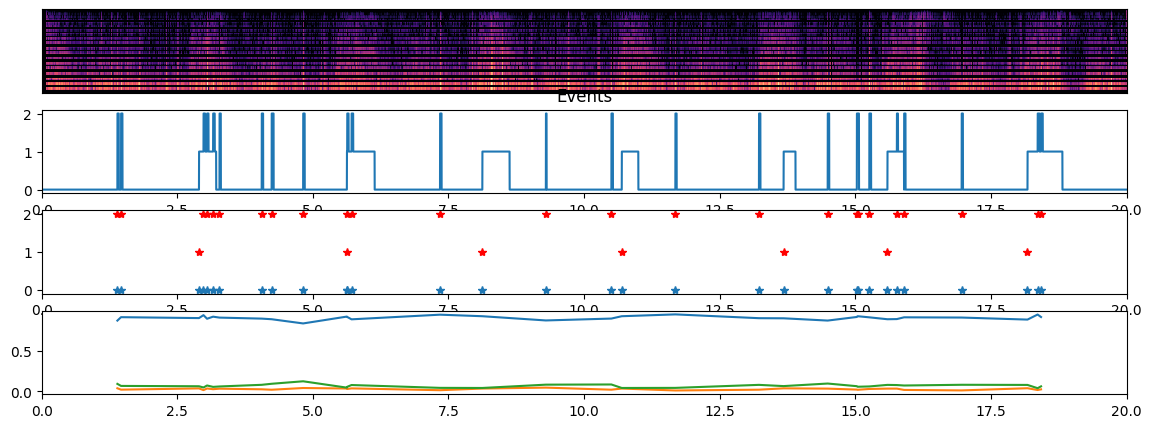

In [105]:
import matplotlib.pyplot as plt
import librosa

f = plt.figure(figsize=(14, 5))
ax = f.add_subplot(411)
librosa.display.specshow(data_feature['data'])
ax = f.add_subplot(412)
ax.plot(data_filtered['time'],data_filtered['label'])
ax.set_xlim([data_filtered['time'][0],data_filtered['time'][-1]])
ax.set_title('Events',y=1)
ax = f.add_subplot(413)
ax.plot(df_label['start'],df_label['label'],'r*')
ax.plot(df_label['start'],df_label['ysample_prediction'],'*')
ax.set_xlim([data_filtered['time'][0],data_filtered['time'][-1]])
ax = f.add_subplot(414)
ax.plot(df_label['start'],ysample_prediction_prob)
ax.set_xlim([data_filtered['time'][0],data_filtered['time'][-1]])